# ResNet-50: CIFAR-10 & PyTorch

In [ ]:
# Specify GPU to be used-
# %env CUDA_DEVICE_ORDER = PCI_BUS_ID
# %env CUDA_VISIBLE_DEVICES = 0

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

from tqdm import tqdm
from tqdm import trange
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import pickle

/home/arjun/anaconda3/envs/pytorch-gpu/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
print(f"torch version: {torch.__version__}")

torch version: 1.11.0


In [3]:
# Check if there are multiple devices (i.e., GPU cards)-
print(f"Number of GPU(s) available = {torch.cuda.device_count()}")

# Which GPU Is The Current GPU?
# print(f"current GPU: {torch.cuda.current_device()}")

# Get the name of the current GPU-
# print(f"Current GPU name: {torch.cuda.get_device_name(torch.cuda.current_device())}")

# Is PyTorch using a GPU?
# print(f"Is PyTorch using a GPU? {torch.cuda.is_available()}")

if torch.cuda.is_available():
    print(f"Current GPU: {torch.cuda.current_device()}")
    print(f"Current GPU name: {torch.cuda.get_device_name(torch.cuda.current_device())}")
else:
    print("PyTorch does not have access to GPU")

Number of GPU(s) available = 2
Current GPU: 0
Current GPU name: NVIDIA GeForce RTX 3080


In [4]:
# Device configuration-
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Available device is {device}')

Available device is cuda


In [5]:
# Specify hyper-parameters
batch_size = 64
num_classes = 10
num_epochs = 85

### CIFAR-10 data pre-processing

In [6]:
# Define transformations for training and test sets-
transform_train = transforms.Compose(
    [
      transforms.RandomCrop(32, padding = 4),
      transforms.RandomHorizontalFlip(),
      transforms.ToTensor(),
      transforms.Normalize(
        mean = (0.4914, 0.4822, 0.4465),
        std = (0.0305, 0.0296, 0.0342)),
     ]
)

transform_test = transforms.Compose(
    [
      transforms.ToTensor(),
      transforms.Normalize(
        mean = (0.4942, 0.4846, 0.4498),
        std = (0.0304, 0.0295, 0.0342)),
     ]
)

In [7]:
train_dataset = torchvision.datasets.CIFAR10(
    root = './data', train = True,
    download = True, transform = transform_train
)

test_dataset = torchvision.datasets.CIFAR10(
    root = './data', train = False,
    download = True, transform = transform_test
)

Files already downloaded and verified
Files already downloaded and verified


In [8]:
train_loader = torch.utils.data.DataLoader(
    dataset = train_dataset, batch_size = batch_size,
    shuffle = True
    )

test_loader = torch.utils.data.DataLoader(
    dataset = test_dataset, batch_size = batch_size,
    shuffle = True
    )

In [9]:
print(f"len(train_dataset) = {len(train_dataset)} & len(test_dataset) = {len(test_dataset)}")

len(train_dataset) = 50000 & len(test_dataset) = 10000


In [10]:
print(f"len(train_loader) = {len(train_loader)} & len(test_loader) = {len(test_loader)}")

len(train_loader) = 782 & len(test_loader) = 157


In [11]:
len(train_dataset) / batch_size, len(test_dataset) / batch_size

(781.25, 156.25)

In [ ]:
def calculate_mean_stddev(data_loader):
    '''
    Compute mean and standard-deviation across all channels for the input
    data loader.
    '''
    # VAR(X) = E(X^2) - E(X) ^ 2
    channels_sum, channels_squared_sum, num_batches = 0, 0, 0
    
    for data, _ in data_loader:
        channels_sum += torch.mean(data, dim = [0, 2, 3])
        # We don't want mean across channels (1st dimension), hence it is ignored.
        
        channels_squared_sum += torch.mean(data ** 2, dim = [0, 2, 3])
        num_batches += 1
    
    mean = channels_sum / num_batches
    std_dev = (channels_squared_sum / num_batches - (mean ** 2)) * 0.5
    # You cannot sum the standard deviation as it is not a linear operation.
    
    return mean, std_dev


In [ ]:
# mean_train, std_dev_train = calculate_mean_stddev(data_loader = train_loader)

In [ ]:
# mean_test, std_dev_test = calculate_mean_stddev(data_loader = test_loader)

In [ ]:
# print(f"CIFAR-10 train dataset: mean = {mean_train} & std-dev = {std_dev_train}")
# print(f"CIFAR-10 train dataset: mean = {mean_test} & std-dev = {std_dev_test}")

# Ignore this due to data augmentations which do not reflect the true data statistics!

### Define _ResNet-50_ CNN architecture

In [12]:
class ResNet_Block(nn.Module):
   
    def __init__(
        self, num_inp_channels,
        num_channels, num_bottleneck_channels,
        stride = 1, dropout = 0.2,
        use_1x1_conv = False, first_resblock = False
    ):
        super(ResNet_Block, self).__init__()
        
        self.num_inp_channels = num_inp_channels
        self.num_channels = num_channels
        self.num_bottleneck_channels = num_bottleneck_channels
        self.stride = stride
        self.dropout = dropout
        self.use_1x1_conv = use_1x1_conv
        self.first_resblock = first_resblock
    
        if self.first_resblock:
            self.conv1 = nn.Conv2d(
                in_channels = self.num_inp_channels, out_channels = self.num_bottleneck_channels,
                kernel_size = 1, padding = 0,
                stride = self.stride, bias = False
            )
            self.bn1 = nn.BatchNorm2d(num_features = self.num_bottleneck_channels)
        else:
            self.conv1 = nn.Conv2d(
                in_channels = self.num_inp_channels, out_channels = self.num_bottleneck_channels,
                kernel_size = 1, padding = 0,
                stride = self.stride, bias = False
            )
            self.bn1 = nn.BatchNorm2d(num_features = self.num_bottleneck_channels)
        
        self.conv2 = nn.Conv2d(
            in_channels = self.num_bottleneck_channels, out_channels = self.num_bottleneck_channels,
            kernel_size = 3, padding = 1,
            stride = 1, bias = False
        )
        self.bn2 = nn.BatchNorm2d(num_features = self.num_bottleneck_channels)
        self.dropout = nn.Dropout(p = self.dropout)
        
        self.conv3 = nn.Conv2d(
            in_channels = self.num_bottleneck_channels, out_channels = self.num_channels,
            kernel_size = 1, padding = 0,
            stride = 1, bias = False
        )
        self.bn3 = nn.BatchNorm2d(num_features = self.num_channels)
        
        if self.use_1x1_conv:
            self.conv4 = nn.Conv2d(
            in_channels = self.num_inp_channels, out_channels = self.num_channels,
            kernel_size = 1, padding = 0,
            stride = self.stride, bias = False
            )
            self.bn4 = nn.BatchNorm2d(num_features = self.num_channels)
        
        self.initialize_weights()

            
    def initialize_weights(self):
        for m in self.modules():
            # print(m)
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight)

                '''
                # Do not initialize bias (due to batchnorm)-
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
                '''
            
            elif isinstance(m, nn.BatchNorm2d):
                # Standard initialization for batch normalization-
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

            elif isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight)
                nn.init.constant_(m.bias, 0)
    
    
    def forward(self, x):
        y = F.relu(self.bn1(self.conv1(x)))
        y = self.dropout(F.relu(self.bn2(self.conv2(y))))
        y = self.dropout(F.relu(self.bn3(self.conv3(y))))
        
        if self.use_1x1_conv:
            x = self.bn4(self.conv4(x))
            
        y += x
        return F.relu(self.dropout(y))
    
    
    def shape_computation(self, x):
        print(f"Input shape: {x.shape}")
        y = F.relu(self.bn1(self.conv1(x)))
        print(f"First conv layer output shape: {y.shape}")
        y = self.bn2(self.conv2(y))
        print(f"Second conv layer output shape: {y.shape}")
        y = self.bn3(self.conv3(y))
        print(f"Third conv layer output shape: {y.shape}")
        
        if self.use_1x1_conv:
            x = self.bn4(self.conv4(x))
            print(f"Downsample with S = 2; identity connection output shape: {x.shape}")
            
        y += x
        print(f"Residual block output shape: {y.shape}")
        return None
    

In [13]:
class ResNet50(nn.Module):
    def __init__(self):
        super(ResNet50, self).__init__()
        
        self.conv1 = nn.Conv2d(
            in_channels = 3, out_channels = 64,
            kernel_size = 3, padding = 1,
            stride = 1, bias = False
        )
        self.bn1 = nn.BatchNorm2d(num_features = 64)
        
        self.resblock1 = ResNet_Block(
            num_inp_channels = 64, num_channels = 256,
            num_bottleneck_channels = 64, stride = 1,
            dropout = 0.2, use_1x1_conv = True,
            first_resblock = True
        )
        
        self.resblock2 = ResNet_Block(
            num_inp_channels = 256, num_channels = 256,
            num_bottleneck_channels = 64, stride = 1,
            dropout = 0.2, use_1x1_conv = True,
            first_resblock = False
        )
        
        self.resblock3 = ResNet_Block(
            num_inp_channels = 256, num_channels = 256,
            num_bottleneck_channels = 64, stride = 1,
            dropout = 0.2, use_1x1_conv = True,
            first_resblock = False
        )
        
        # Downsample-
        self.resblock4 = ResNet_Block(
            num_inp_channels = 256, num_channels = 512,
            num_bottleneck_channels = 128, stride = 2,
            dropout = 0.2, use_1x1_conv = True,
            first_resblock = False
        )
        
        self.resblock5 = ResNet_Block(
            num_inp_channels = 512, num_channels = 512,
            num_bottleneck_channels = 128, stride = 1,
            dropout = 0.2, use_1x1_conv = True,
            first_resblock = False
        )
        
        self.resblock6 = ResNet_Block(
            num_inp_channels = 512, num_channels = 512,
            num_bottleneck_channels = 128, stride = 1,
            dropout = 0.2, use_1x1_conv = True,
            first_resblock = False
        )
        
        self.resblock7 = ResNet_Block(
            num_inp_channels = 512, num_channels = 512,
            num_bottleneck_channels = 128, stride = 1,
            dropout = 0.2, use_1x1_conv = True,
            first_resblock = False
        )
        
        # Downsample-
        self.resblock8 = ResNet_Block(
            num_inp_channels = 512, num_channels = 1024,
            num_bottleneck_channels = 256, stride = 2,
            dropout = 0.2, use_1x1_conv = True,
            first_resblock = False
        )
        
        self.resblock9 = ResNet_Block(
            num_inp_channels = 1024, num_channels = 1024,
            num_bottleneck_channels = 256, stride = 1,
            dropout = 0.2, use_1x1_conv = True,
            first_resblock = False
        )
        
        self.resblock10 = ResNet_Block(
            num_inp_channels = 1024, num_channels = 1024,
            num_bottleneck_channels = 256, stride = 1,
            dropout = 0.2, use_1x1_conv = True,
            first_resblock = False
        )
        
        self.resblock11 = resblock9 = ResNet_Block(
            num_inp_channels = 1024, num_channels = 1024,
            num_bottleneck_channels = 256, stride = 1,
            dropout = 0.2, use_1x1_conv = True,
            first_resblock = False
        )
        
        self.resblock12 = resblock9 = ResNet_Block(
            num_inp_channels = 1024, num_channels = 1024,
            num_bottleneck_channels = 256, stride = 1,
            dropout = 0.2, use_1x1_conv = True,
            first_resblock = False
        )
        
        self.resblock13 = resblock9 = ResNet_Block(
            num_inp_channels = 1024, num_channels = 1024,
            num_bottleneck_channels = 256, stride = 1,
            dropout = 0.2, use_1x1_conv = True,
            first_resblock = False
        )
        
        # Downsample-
        self.resblock14 = ResNet_Block(
            num_inp_channels = 1024, num_channels = 2048,
            num_bottleneck_channels = 512, stride = 2,
            dropout = 0.2, use_1x1_conv = True,
            first_resblock = False
        )
        
        self.resblock15 = ResNet_Block(
            num_inp_channels = 2048, num_channels = 2048,
            num_bottleneck_channels = 512, stride = 1,
            dropout = 0.2, use_1x1_conv = True,
            first_resblock = False
        )
        
        self.resblock16 = ResNet_Block(
            num_inp_channels = 2048, num_channels = 2048,
            num_bottleneck_channels = 512, stride = 1,
            dropout = 0.2, use_1x1_conv = True,
            first_resblock = False
        )
        
        # self.avg_pool = nn.AvgPool2d(kernel_size = 3, stride = 2)
        self.avg_pool = nn.AdaptiveAvgPool2d(output_size = (1, 1))
        self.output_layer = nn.Linear(in_features = 2048, out_features = 10)
        
        
    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.resblock1(x)
        x = self.resblock2(x)
        x = self.resblock3(x)
        x = self.resblock4(x)
        x = self.resblock5(x)
        x = self.resblock6(x)
        x = self.resblock7(x)
        x = self.resblock8(x)
        x = self.resblock9(x)
        x = self.resblock10(x)
        x = self.resblock11(x)
        x = self.resblock12(x)
        x = self.resblock13(x)
        x = self.resblock14(x)
        x = self.resblock15(x)
        x = self.resblock16(x)
        x = self.avg_pool(x).squeeze()
        x = self.output_layer(x)
        return x
    
    
    def shape_computation(self, x):
        print(f"Input shape: {x.shape}")
        x = F.relu(self.bn1(self.conv1(x)))
        print(f"First conv layer output shape: {x.shape}")
        x = self.resblock1(x)
        print(f"ResBlock 1 output shape: {x.shape}")
        x = self.resblock2(x)
        print(f"ResBlock 2 output shape: {x.shape}")
        x = self.resblock3(x)
        print(f"ResBlock 3 output shape: {x.shape}")
        x = self.resblock4(x)
        print(f"ResBlock 4 output shape: {x.shape}")
        x = self.resblock5(x)
        print(f"ResBlock 5 output shape: {x.shape}")
        x = self.resblock6(x)
        print(f"ResBlock 6 output shape: {x.shape}")
        x = self.resblock7(x)
        print(f"ResBlock 7 output shape: {x.shape}")
        x = self.resblock8(x)
        print(f"ResBlock 8 output shape: {x.shape}")
        x = self.resblock9(x)
        print(f"ResBlock 9 output shape: {x.shape}")
        x = self.resblock10(x)
        print(f"ResBlock 10 output shape: {x.shape}")
        x = self.resblock11(x)
        print(f"ResBlock 11 output shape: {x.shape}")
        x = self.resblock12(x)
        print(f"ResBlock 12 output shape: {x.shape}")
        x = self.resblock13(x)
        print(f"ResBlock 13 output shape: {x.shape}")
        x = self.resblock14(x)
        print(f"ResBlock 14 output shape: {x.shape}")
        x = self.resblock15(x)
        print(f"ResBlock 15 output shape: {x.shape}")
        x = self.resblock16(x)
        print(f"ResBlock 16 output shape: {x.shape}")
        x = self.avg_pool(x).squeeze()
        print(f"Average pool output shape: {x.shape}")
        x = self.output_layer(x)
        print(f"Output layer shape: {x.shape}")
        del x
        return None
        
    

### Multi-GPU Training in PyTorch

- [Multi-GPU Examples](https://pytorch.org/tutorials/beginner/former_torchies/parallelism_tutorial.html)

- [Data Parallelism](https://pytorch.org/tutorials/beginner/blitz/data_parallel_tutorial.html)

In [14]:
# Initialize ResNet-50 architecture-
model = ResNet50()

In [ ]:
# Use all available GPUs-
model = nn.DataParallel(model)
model.to(device)

In [16]:
# Sanity check-
x, y = next(iter(train_loader))
x = x.to(device)
y = y.to(device)

In [17]:
x.shape, y.shape

(torch.Size([64, 3, 32, 32]), torch.Size([64]))

In [18]:
out = model(x)

In [19]:
out.shape

torch.Size([64, 10])

In [20]:
del x, y, out

In [21]:
# Count number of layer-wise parameters and total parameters-
tot_params = 0
for param in model.parameters():
    print(f"layer.shape = {param.shape} has {param.nelement()} parameters")
    tot_params += param.nelement()

layer.shape = torch.Size([64, 3, 3, 3]) has 1728 parameters
layer.shape = torch.Size([64]) has 64 parameters
layer.shape = torch.Size([64]) has 64 parameters
layer.shape = torch.Size([64, 64, 1, 1]) has 4096 parameters
layer.shape = torch.Size([64]) has 64 parameters
layer.shape = torch.Size([64]) has 64 parameters
layer.shape = torch.Size([64, 64, 3, 3]) has 36864 parameters
layer.shape = torch.Size([64]) has 64 parameters
layer.shape = torch.Size([64]) has 64 parameters
layer.shape = torch.Size([256, 64, 1, 1]) has 16384 parameters
layer.shape = torch.Size([256]) has 256 parameters
layer.shape = torch.Size([256]) has 256 parameters
layer.shape = torch.Size([256, 64, 1, 1]) has 16384 parameters
layer.shape = torch.Size([256]) has 256 parameters
layer.shape = torch.Size([256]) has 256 parameters
layer.shape = torch.Size([64, 256, 1, 1]) has 16384 parameters
layer.shape = torch.Size([64]) has 64 parameters
layer.shape = torch.Size([64]) has 64 parameters
layer.shape = torch.Size([64, 64

In [22]:
print(f"Total number of parameters in ResNet-50 CNN = {tot_params}")

Total number of parameters in ResNet-50 CNN = 38092362


In [ ]:
'''
# Print layer names-
for layer in model.state_dict().keys():
    print(f"{layer} has dimension = {model.state_dict()[layer].shape}")
'''

In [ ]:
# Save random initial weights-
# torch.save(model.state_dict(), 'ResNet50_random_weights.pth')

In [ ]:
# Load randomly initialised weights-
'''
test_model = ResNet50()
test_model = nn.DataParallel(test_model)
test_model.to(device)
test_model.load_state_dict(torch.load("ResNet50_random_weights.pth"))
'''

### Train _ResNet-50_ CNN with Learning Rate Scheduler

Training dataset size = 50K, batch-size = 64, number of training steps per epoch = 50K / 64 = 781.25

After an initial LR warmup of 13 epochs or, 10156.25 = 10157 training iterations:

- For the next 32 epochs, or, 25000 steps - until 45rd epoch, use lr = 0.1.

- For the next 25 epochs, or, 19531.25 steps - until 70th epoch, use lr = 0.01.

- For remaining epochs, use lr = 0.001.

In [23]:
boundaries = [35157, 53125]
values = [0.1, 0.01, 0.001]

In [24]:
# Define loss function and optimizer-
loss = nn.CrossEntropyLoss()

# optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
optimizer = torch.optim.SGD(model.parameters(), lr = 0.0, momentum = 0.9, weight_decay = 5e-4)

In [25]:
# Sanity check-
optimizer.param_groups[0]['lr']

0.0

In [26]:
def decay_function(step, boundaries = [35157, 53125], values = [0.1, 0.01, 0.001]):
    
    for idx, bound in enumerate(boundaries):
        if step < bound:
            return values[idx]

    return values[-1]


In [27]:
class schedule():

    def __init__(self, initial_learning_rate = 0.1, warmup_steps = 1000, decay_func = None):
        self.initial_learning_rate = initial_learning_rate
        self.warmup_steps = warmup_steps
        self.decay_func = decay_func
        self.warmup_step_size = initial_learning_rate/warmup_steps
        self.current_lr = 0

    def get_lr(self, step):
        if step == 0:
            return self.current_lr
        elif step <= self.warmup_steps:
            self.current_lr+=self.warmup_step_size
            return self.current_lr
        elif step > self.warmup_steps:
            if self.decay_func:
                return self.decay_func(step)
        else:
            return self.current_lr
        

In [28]:
# Initial linear LR warmup: 781.25 x 13 = 10156.25 steps in 13 epochs.
custom_lr_scheduler = schedule(
    initial_learning_rate = 0.1, warmup_steps = 10157,
    decay_func = decay_function
)

In [29]:
step = 0

In [30]:
def train_model_progress(model, train_loader):
    '''
    Function to perform one epoch of training by using 'train_loader'.
    Returns loss and number of correct predictions for this epoch.
    '''
    running_loss = 0.0
    running_corrects = 0.0
    
    model.train()
    
    with tqdm(train_loader, unit = 'batch') as tepoch:
        for images, labels in tepoch:
            tepoch.set_description(f"Training: ")
            
            images = images.to(device)
            labels = labels.to(device)
            
            # Get model predictions-
            outputs = model(images)
            
            # Compute loss-
            J = loss(outputs, labels)
            
            # Empty accumulated gradients-
            optimizer.zero_grad()
            
            # Perform backprop-
            J.backward()
            
            # Update parameters-
            optimizer.step()
            
            global step
            optimizer.param_groups[0]['lr'] = custom_lr_scheduler.get_lr(step)

            step += 1
            
            # Compute model's performance statistics-
            running_loss += J.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            running_corrects += torch.sum(predicted == labels.data)
            
            tepoch.set_postfix(
                loss = running_loss / len(train_dataset),
                accuracy = (running_corrects.double().cpu().numpy() / len(train_dataset)) * 100
            )
            
    
    train_loss = running_loss / len(train_dataset)
    train_acc = (running_corrects.double() / len(train_dataset)) * 100
    

    # return running_loss, running_corrects
    return train_loss, train_acc.cpu().numpy()


In [31]:
def test_model_progress(model, test_loader):
    total = 0.0
    correct = 0.0
    running_loss_val = 0.0

    with torch.no_grad():
        with tqdm(test_loader, unit = 'batch') as tepoch:
            for images, labels in tepoch:
                tepoch.set_description(f"Validation: ")
                
                images = images.to(device)
                labels = labels.to(device)
                
                # Set model to evaluation mode-
                model.eval()
            
                # Predict using trained model-
                outputs = model(images)
                _, y_pred = torch.max(outputs, 1)
                
                # Compute validation loss-
                J_val = loss(outputs, labels)
                
                running_loss_val += J_val.item() * labels.size(0)
    
                # Total number of labels-
                total += labels.size(0)

                # Total number of correct predictions-
                correct += (y_pred == labels).sum()
                
                tepoch.set_postfix(
                    val_loss = running_loss_val / len(test_dataset),
                    val_acc = 100 * (correct.cpu().numpy() / total)
                )
            
        
    # return (running_loss_val, correct, total)
    val_loss = running_loss_val / len(test_dataset)
    val_acc = (correct / total) * 100

    return val_loss, val_acc.cpu().numpy()


In [32]:
# Python3 dict to contain training metrics-
training_history_lr_scheduler = {}

In [33]:
# Initialize parameters saving 'best' models-
best_val_loss = 100
loc_patience = 0

In [34]:
for epoch in range(num_epochs):

    # Train and validate model for 1 epoch-
    train_loss, train_acc = train_model_progress(model, train_loader)
    val_loss, val_acc = test_model_progress(model, test_loader)
    
    print(f"\nepoch: {epoch + 1} training loss = {train_loss:.4f}, "
          f"training accuracy = {train_acc:.2f}%, val_loss = {val_loss:.4f}"
          f", val_accuracy = {val_acc:.2f}% & "
          f"LR = {optimizer.param_groups[0]['lr']:.4f}\n")
    
    training_history_lr_scheduler[epoch + 1] = {
        'loss': train_loss, 'acc': train_acc,
        'val_loss': val_loss, 'val_acc': val_acc,
        'lr': optimizer.param_groups[0]['lr']
    }

    
    # Save best weights achieved until now-
    if (val_loss < best_val_loss):    
        # update 'best_val_loss' variable to lowest loss encountered so far-
        best_val_loss = val_loss

        print(f"Saving model with lowest val_loss = {val_loss:.4f}\n")
        
        # Save trained model with 'best' validation accuracy-
        torch.save(model.state_dict(), "ResNet50_best_model.pth")
        

Validation: : 100%|██████████████████████████| 157/157 [00:08<00:00, 18.13batch/s, val_acc=10, val_loss=4.43]



epoch: 1 training loss = 2.3389, training accuracy = 13.97%, val_loss = 4.4263, val_accuracy = 10.00% & LR = 0.0077

Saving model with lowest val_loss = 4.4263



Validation: : 100%|████████████████████████| 157/157 [00:08<00:00, 17.98batch/s, val_acc=10.4, val_loss=4.46]



epoch: 2 training loss = 2.0942, training accuracy = 19.67%, val_loss = 4.4635, val_accuracy = 10.45% & LR = 0.0154



Validation: : 100%|████████████████████████| 157/157 [00:08<00:00, 18.02batch/s, val_acc=12.7, val_loss=3.34]



epoch: 3 training loss = 1.9373, training accuracy = 24.41%, val_loss = 3.3352, val_accuracy = 12.73% & LR = 0.0231

Saving model with lowest val_loss = 3.3352



Validation: : 100%|████████████████████████| 157/157 [00:08<00:00, 18.06batch/s, val_acc=26.1, val_loss=2.38]



epoch: 4 training loss = 1.7741, training accuracy = 32.26%, val_loss = 2.3844, val_accuracy = 26.11% & LR = 0.0308

Saving model with lowest val_loss = 2.3844



Validation: : 100%|███████████████████████████| 157/157 [00:08<00:00, 18.15batch/s, val_acc=43, val_loss=1.7]



epoch: 5 training loss = 1.5686, training accuracy = 41.08%, val_loss = 1.6971, val_accuracy = 42.96% & LR = 0.0385

Saving model with lowest val_loss = 1.6971



Validation: : 100%|█████████████████████████| 157/157 [00:08<00:00, 18.12batch/s, val_acc=47.3, val_loss=1.6]



epoch: 6 training loss = 1.3644, training accuracy = 50.22%, val_loss = 1.5983, val_accuracy = 47.31% & LR = 0.0462

Saving model with lowest val_loss = 1.5983



Validation: : 100%|████████████████████████| 157/157 [00:08<00:00, 18.15batch/s, val_acc=49.9, val_loss=1.66]



epoch: 7 training loss = 1.2238, training accuracy = 56.21%, val_loss = 1.6606, val_accuracy = 49.92% & LR = 0.0539



Validation: : 100%|████████████████████████| 157/157 [00:08<00:00, 17.86batch/s, val_acc=59.6, val_loss=1.16]



epoch: 8 training loss = 1.1518, training accuracy = 59.05%, val_loss = 1.1581, val_accuracy = 59.59% & LR = 0.0616

Saving model with lowest val_loss = 1.1581



Validation: : 100%|████████████████████████| 157/157 [00:08<00:00, 17.77batch/s, val_acc=62.2, val_loss=1.07]



epoch: 9 training loss = 1.0923, training accuracy = 61.63%, val_loss = 1.0660, val_accuracy = 62.24% & LR = 0.0693

Saving model with lowest val_loss = 1.0660



Validation: : 100%|████████████████████████| 157/157 [00:08<00:00, 18.05batch/s, val_acc=57.5, val_loss=1.34]



epoch: 10 training loss = 1.0606, training accuracy = 62.57%, val_loss = 1.3384, val_accuracy = 57.53% & LR = 0.0770



Validation: : 100%|████████████████████████| 157/157 [00:08<00:00, 17.78batch/s, val_acc=63.9, val_loss=1.05]



epoch: 11 training loss = 1.0460, training accuracy = 63.16%, val_loss = 1.0500, val_accuracy = 63.94% & LR = 0.0847

Saving model with lowest val_loss = 1.0500



Validation: : 100%|████████████████████████| 157/157 [00:08<00:00, 18.05batch/s, val_acc=63.7, val_loss=1.05]



epoch: 12 training loss = 1.0277, training accuracy = 63.98%, val_loss = 1.0475, val_accuracy = 63.73% & LR = 0.0924

Saving model with lowest val_loss = 1.0475



Validation: : 100%|████████████████████████| 157/157 [00:08<00:00, 18.05batch/s, val_acc=58.4, val_loss=1.28]



epoch: 13 training loss = 1.0200, training accuracy = 64.51%, val_loss = 1.2805, val_accuracy = 58.37% & LR = 0.1000



Validation: : 100%|██████████████████████████| 157/157 [00:08<00:00, 18.03batch/s, val_acc=61, val_loss=1.18]



epoch: 14 training loss = 1.0083, training accuracy = 64.85%, val_loss = 1.1813, val_accuracy = 60.98% & LR = 0.1000



Validation: : 100%|████████████████████████| 157/157 [00:08<00:00, 17.96batch/s, val_acc=64.9, val_loss=1.07]



epoch: 15 training loss = 0.9941, training accuracy = 65.47%, val_loss = 1.0713, val_accuracy = 64.93% & LR = 0.1000



Validation: : 100%|████████████████████████| 157/157 [00:08<00:00, 18.08batch/s, val_acc=57.4, val_loss=1.34]



epoch: 16 training loss = 0.9804, training accuracy = 66.19%, val_loss = 1.3401, val_accuracy = 57.41% & LR = 0.1000



Validation: : 100%|███████████████████████████| 157/157 [00:08<00:00, 18.06batch/s, val_acc=67.2, val_loss=1]



epoch: 17 training loss = 0.9682, training accuracy = 66.29%, val_loss = 1.0021, val_accuracy = 67.23% & LR = 0.1000

Saving model with lowest val_loss = 1.0021



Validation: : 100%|████████████████████████| 157/157 [00:08<00:00, 18.00batch/s, val_acc=66.6, val_loss=1.01]



epoch: 18 training loss = 0.9562, training accuracy = 66.97%, val_loss = 1.0106, val_accuracy = 66.60% & LR = 0.1000



Validation: : 100%|████████████████████████| 157/157 [00:08<00:00, 18.01batch/s, val_acc=62.7, val_loss=1.15]



epoch: 19 training loss = 0.9530, training accuracy = 67.16%, val_loss = 1.1468, val_accuracy = 62.72% & LR = 0.1000



Validation: : 100%|████████████████████████| 157/157 [00:08<00:00, 17.98batch/s, val_acc=64.5, val_loss=1.09]



epoch: 20 training loss = 0.9486, training accuracy = 67.39%, val_loss = 1.0888, val_accuracy = 64.50% & LR = 0.1000



Validation: : 100%|███████████████████████| 157/157 [00:08<00:00, 17.99batch/s, val_acc=66.4, val_loss=0.994]



epoch: 21 training loss = 0.9420, training accuracy = 67.37%, val_loss = 0.9945, val_accuracy = 66.39% & LR = 0.1000

Saving model with lowest val_loss = 0.9945



Validation: : 100%|████████████████████████| 157/157 [00:08<00:00, 17.94batch/s, val_acc=63.6, val_loss=1.11]



epoch: 22 training loss = 0.9409, training accuracy = 67.40%, val_loss = 1.1077, val_accuracy = 63.61% & LR = 0.1000



Validation: : 100%|████████████████████████| 157/157 [00:08<00:00, 18.03batch/s, val_acc=61.1, val_loss=1.17]



epoch: 23 training loss = 0.9356, training accuracy = 67.58%, val_loss = 1.1738, val_accuracy = 61.07% & LR = 0.1000



Validation: : 100%|████████████████████████| 157/157 [00:08<00:00, 18.00batch/s, val_acc=61.8, val_loss=1.18]



epoch: 24 training loss = 0.9311, training accuracy = 67.64%, val_loss = 1.1806, val_accuracy = 61.78% & LR = 0.1000



Validation: : 100%|██████████████████████████| 157/157 [00:08<00:00, 18.01batch/s, val_acc=63, val_loss=1.14]



epoch: 25 training loss = 0.9358, training accuracy = 67.59%, val_loss = 1.1402, val_accuracy = 62.99% & LR = 0.1000



Validation: : 100%|████████████████████████| 157/157 [00:08<00:00, 18.08batch/s, val_acc=65.8, val_loss=1.02]



epoch: 26 training loss = 0.9297, training accuracy = 67.72%, val_loss = 1.0206, val_accuracy = 65.76% & LR = 0.1000



Validation: : 100%|████████████████████████| 157/157 [00:08<00:00, 18.13batch/s, val_acc=57.8, val_loss=1.38]



epoch: 27 training loss = 0.9305, training accuracy = 67.64%, val_loss = 1.3823, val_accuracy = 57.77% & LR = 0.1000



Validation: : 100%|████████████████████████| 157/157 [00:08<00:00, 18.05batch/s, val_acc=65.2, val_loss=1.05]



epoch: 28 training loss = 0.9337, training accuracy = 67.77%, val_loss = 1.0535, val_accuracy = 65.18% & LR = 0.1000



Validation: : 100%|████████████████████████| 157/157 [00:08<00:00, 18.11batch/s, val_acc=63.4, val_loss=1.12]



epoch: 29 training loss = 0.9314, training accuracy = 67.87%, val_loss = 1.1211, val_accuracy = 63.36% & LR = 0.1000



Validation: : 100%|████████████████████████| 157/157 [00:08<00:00, 18.10batch/s, val_acc=58.4, val_loss=1.44]



epoch: 30 training loss = 0.9264, training accuracy = 67.87%, val_loss = 1.4414, val_accuracy = 58.44% & LR = 0.1000



Validation: : 100%|████████████████████████| 157/157 [00:08<00:00, 17.99batch/s, val_acc=65.8, val_loss=1.09]



epoch: 31 training loss = 0.9259, training accuracy = 68.00%, val_loss = 1.0874, val_accuracy = 65.75% & LR = 0.1000



Validation: : 100%|████████████████████████| 157/157 [00:08<00:00, 17.99batch/s, val_acc=63.7, val_loss=1.14]



epoch: 32 training loss = 0.9172, training accuracy = 68.51%, val_loss = 1.1370, val_accuracy = 63.75% & LR = 0.1000



Validation: : 100%|████████████████████████| 157/157 [00:08<00:00, 17.99batch/s, val_acc=59.9, val_loss=1.27]



epoch: 33 training loss = 0.9247, training accuracy = 68.00%, val_loss = 1.2727, val_accuracy = 59.88% & LR = 0.1000



Validation: : 100%|████████████████████████| 157/157 [00:08<00:00, 18.04batch/s, val_acc=67.8, val_loss=0.97]



epoch: 34 training loss = 0.9222, training accuracy = 68.16%, val_loss = 0.9701, val_accuracy = 67.83% & LR = 0.1000

Saving model with lowest val_loss = 0.9701



Validation: : 100%|███████████████████████| 157/157 [00:08<00:00, 18.04batch/s, val_acc=67.3, val_loss=0.951]



epoch: 35 training loss = 0.9161, training accuracy = 68.31%, val_loss = 0.9515, val_accuracy = 67.27% & LR = 0.1000

Saving model with lowest val_loss = 0.9515



Validation: : 100%|██████████████████████████████████████████████████████████████████| 157/157 [00:08<00:00, 17.91batch/s, val_acc=70.6, val_loss=0.895]



epoch: 36 training loss = 0.9212, training accuracy = 68.23%, val_loss = 0.8951, val_accuracy = 70.57% & LR = 0.1000

Saving model with lowest val_loss = 0.8951



Validation: : 100%|██████████████████████████████████████████████████████████████████| 157/157 [00:08<00:00, 18.02batch/s, val_acc=67.5, val_loss=0.975]



epoch: 37 training loss = 0.9205, training accuracy = 68.00%, val_loss = 0.9747, val_accuracy = 67.48% & LR = 0.1000



Validation: : 100%|███████████████████████████████████████████████████████████████████| 157/157 [00:08<00:00, 18.00batch/s, val_acc=60.4, val_loss=1.33]



epoch: 38 training loss = 0.9217, training accuracy = 68.26%, val_loss = 1.3323, val_accuracy = 60.36% & LR = 0.1000



Validation: : 100%|███████████████████████████████████████████████████████████████████| 157/157 [00:08<00:00, 18.04batch/s, val_acc=63.2, val_loss=1.22]



epoch: 39 training loss = 0.9197, training accuracy = 68.37%, val_loss = 1.2250, val_accuracy = 63.24% & LR = 0.1000



Validation: : 100%|███████████████████████████████████████████████████████████████████| 157/157 [00:08<00:00, 17.95batch/s, val_acc=59.7, val_loss=1.34]



epoch: 40 training loss = 0.9185, training accuracy = 68.33%, val_loss = 1.3383, val_accuracy = 59.72% & LR = 0.1000



Validation: : 100%|███████████████████████████████████████████████████████████████████| 157/157 [00:08<00:00, 18.04batch/s, val_acc=58.6, val_loss=1.35]



epoch: 41 training loss = 0.9226, training accuracy = 68.00%, val_loss = 1.3530, val_accuracy = 58.60% & LR = 0.1000



Validation: : 100%|███████████████████████████████████████████████████████████████████| 157/157 [00:08<00:00, 18.10batch/s, val_acc=58.8, val_loss=1.38]



epoch: 42 training loss = 0.9165, training accuracy = 68.39%, val_loss = 1.3779, val_accuracy = 58.79% & LR = 0.1000



Validation: : 100%|███████████████████████████████████████████████████████████████████| 157/157 [00:08<00:00, 18.01batch/s, val_acc=57.1, val_loss=1.36]



epoch: 43 training loss = 0.9184, training accuracy = 68.27%, val_loss = 1.3574, val_accuracy = 57.09% & LR = 0.1000



Validation: : 100%|███████████████████████████████████████████████████████████████████| 157/157 [00:08<00:00, 18.07batch/s, val_acc=65.6, val_loss=1.02]



epoch: 44 training loss = 0.9090, training accuracy = 68.57%, val_loss = 1.0199, val_accuracy = 65.63% & LR = 0.1000



Validation: : 100%|██████████████████████████████████████████████████████████████████| 157/157 [00:08<00:00, 18.14batch/s, val_acc=75.3, val_loss=0.707]



epoch: 45 training loss = 0.9199, training accuracy = 68.35%, val_loss = 0.7072, val_accuracy = 75.35% & LR = 0.0100

Saving model with lowest val_loss = 0.7072



Validation: : 100%|███████████████████████████████████████████████████████████████████| 157/157 [00:08<00:00, 18.06batch/s, val_acc=81.6, val_loss=0.54]



epoch: 46 training loss = 0.6629, training accuracy = 77.22%, val_loss = 0.5402, val_accuracy = 81.58% & LR = 0.0100

Saving model with lowest val_loss = 0.5402



Validation: : 100%|██████████████████████████████████████████████████████████████████| 157/157 [00:08<00:00, 18.09batch/s, val_acc=82.1, val_loss=0.522]



epoch: 47 training loss = 0.6043, training accuracy = 79.10%, val_loss = 0.5219, val_accuracy = 82.14% & LR = 0.0100

Saving model with lowest val_loss = 0.5219



Validation: : 100%|██████████████████████████████████████████████████████████████████| 157/157 [00:08<00:00, 18.02batch/s, val_acc=83.3, val_loss=0.486]



epoch: 48 training loss = 0.5790, training accuracy = 80.18%, val_loss = 0.4863, val_accuracy = 83.26% & LR = 0.0100

Saving model with lowest val_loss = 0.4863



Validation: : 100%|██████████████████████████████████████████████████████████████████| 157/157 [00:08<00:00, 18.18batch/s, val_acc=82.3, val_loss=0.514]



epoch: 49 training loss = 0.5578, training accuracy = 80.71%, val_loss = 0.5138, val_accuracy = 82.34% & LR = 0.0100



Validation: : 100%|████████████████████████████████████████████████████████████████████| 157/157 [00:08<00:00, 18.26batch/s, val_acc=84, val_loss=0.478]



epoch: 50 training loss = 0.5462, training accuracy = 81.18%, val_loss = 0.4785, val_accuracy = 84.00% & LR = 0.0100

Saving model with lowest val_loss = 0.4785



Validation: : 100%|██████████████████████████████████████████████████████████████████| 157/157 [00:08<00:00, 18.29batch/s, val_acc=84.6, val_loss=0.448]



epoch: 51 training loss = 0.5332, training accuracy = 81.72%, val_loss = 0.4481, val_accuracy = 84.64% & LR = 0.0100

Saving model with lowest val_loss = 0.4481



Validation: : 100%|████████████████████████████████████████████████████████████████████| 157/157 [00:08<00:00, 18.32batch/s, val_acc=84, val_loss=0.465]



epoch: 52 training loss = 0.5236, training accuracy = 81.91%, val_loss = 0.4652, val_accuracy = 83.95% & LR = 0.0100



Validation: : 100%|██████████████████████████████████████████████████████████████████| 157/157 [00:08<00:00, 18.30batch/s, val_acc=84.9, val_loss=0.442]



epoch: 53 training loss = 0.5159, training accuracy = 82.30%, val_loss = 0.4420, val_accuracy = 84.88% & LR = 0.0100

Saving model with lowest val_loss = 0.4420



Validation: : 100%|██████████████████████████████████████████████████████████████████| 157/157 [00:08<00:00, 18.24batch/s, val_acc=84.2, val_loss=0.461]



epoch: 54 training loss = 0.5103, training accuracy = 82.49%, val_loss = 0.4613, val_accuracy = 84.16% & LR = 0.0100



Validation: : 100%|██████████████████████████████████████████████████████████████████| 157/157 [00:08<00:00, 18.32batch/s, val_acc=84.7, val_loss=0.457]



epoch: 55 training loss = 0.5067, training accuracy = 82.54%, val_loss = 0.4570, val_accuracy = 84.74% & LR = 0.0100



Validation: : 100%|██████████████████████████████████████████████████████████████████| 157/157 [00:08<00:00, 18.40batch/s, val_acc=83.2, val_loss=0.498]



epoch: 56 training loss = 0.5025, training accuracy = 82.81%, val_loss = 0.4981, val_accuracy = 83.20% & LR = 0.0100



Validation: : 100%|████████████████████████████████████████████████████████████████████| 157/157 [00:08<00:00, 18.27batch/s, val_acc=85, val_loss=0.431]



epoch: 57 training loss = 0.5016, training accuracy = 82.73%, val_loss = 0.4310, val_accuracy = 85.03% & LR = 0.0100

Saving model with lowest val_loss = 0.4310



Validation: : 100%|██████████████████████████████████████████████████████████████████| 157/157 [00:08<00:00, 18.19batch/s, val_acc=82.8, val_loss=0.508]



epoch: 58 training loss = 0.4960, training accuracy = 82.96%, val_loss = 0.5078, val_accuracy = 82.76% & LR = 0.0100



Validation: : 100%|██████████████████████████████████████████████████████████████████| 157/157 [00:08<00:00, 18.12batch/s, val_acc=84.1, val_loss=0.469]



epoch: 59 training loss = 0.4922, training accuracy = 83.15%, val_loss = 0.4691, val_accuracy = 84.09% & LR = 0.0100



Validation: : 100%|██████████████████████████████████████████████████████████████████| 157/157 [00:08<00:00, 18.21batch/s, val_acc=85.2, val_loss=0.436]



epoch: 60 training loss = 0.4937, training accuracy = 83.12%, val_loss = 0.4363, val_accuracy = 85.15% & LR = 0.0100



Validation: : 100%|██████████████████████████████████████████████████████████████████| 157/157 [00:08<00:00, 18.28batch/s, val_acc=84.2, val_loss=0.465]



epoch: 61 training loss = 0.4880, training accuracy = 83.30%, val_loss = 0.4648, val_accuracy = 84.24% & LR = 0.0100



Validation: : 100%|██████████████████████████████████████████████████████████████████| 157/157 [00:08<00:00, 18.19batch/s, val_acc=84.1, val_loss=0.466]



epoch: 62 training loss = 0.4877, training accuracy = 83.21%, val_loss = 0.4655, val_accuracy = 84.07% & LR = 0.0100



Validation: : 100%|██████████████████████████████████████████████████████████████████| 157/157 [00:08<00:00, 17.67batch/s, val_acc=84.4, val_loss=0.451]



epoch: 63 training loss = 0.4792, training accuracy = 83.67%, val_loss = 0.4515, val_accuracy = 84.39% & LR = 0.0100



Validation: : 100%|██████████████████████████████████████████████████████████████████| 157/157 [00:08<00:00, 18.04batch/s, val_acc=84.2, val_loss=0.464]



epoch: 64 training loss = 0.4857, training accuracy = 83.33%, val_loss = 0.4644, val_accuracy = 84.24% & LR = 0.0100



Validation: : 100%|██████████████████████████████████████████████████████████████████| 157/157 [00:08<00:00, 18.00batch/s, val_acc=85.2, val_loss=0.428]



epoch: 65 training loss = 0.4755, training accuracy = 83.59%, val_loss = 0.4279, val_accuracy = 85.18% & LR = 0.0100

Saving model with lowest val_loss = 0.4279



Validation: : 100%|██████████████████████████████████████████████████████████████████| 157/157 [00:08<00:00, 17.99batch/s, val_acc=85.9, val_loss=0.417]



epoch: 66 training loss = 0.4770, training accuracy = 83.81%, val_loss = 0.4168, val_accuracy = 85.88% & LR = 0.0100

Saving model with lowest val_loss = 0.4168



Validation: : 100%|██████████████████████████████████████████████████████████████████| 157/157 [00:08<00:00, 17.97batch/s, val_acc=84.9, val_loss=0.435]



epoch: 67 training loss = 0.4779, training accuracy = 83.56%, val_loss = 0.4352, val_accuracy = 84.93% & LR = 0.0100



Validation: : 100%|██████████████████████████████████████████████████████████████████| 157/157 [00:08<00:00, 18.13batch/s, val_acc=86.7, val_loss=0.383]



epoch: 68 training loss = 0.4745, training accuracy = 83.68%, val_loss = 0.3826, val_accuracy = 86.73% & LR = 0.0010

Saving model with lowest val_loss = 0.3826



Validation: : 100%|██████████████████████████████████████████████████████████████████| 157/157 [00:08<00:00, 17.95batch/s, val_acc=88.7, val_loss=0.338]



epoch: 69 training loss = 0.3736, training accuracy = 87.25%, val_loss = 0.3379, val_accuracy = 88.70% & LR = 0.0010

Saving model with lowest val_loss = 0.3379



Validation: : 100%|██████████████████████████████████████████████████████████████████| 157/157 [00:08<00:00, 18.02batch/s, val_acc=88.8, val_loss=0.327]



epoch: 70 training loss = 0.3546, training accuracy = 87.66%, val_loss = 0.3272, val_accuracy = 88.78% & LR = 0.0010

Saving model with lowest val_loss = 0.3272



Validation: : 100%|██████████████████████████████████████████████████████████████████| 157/157 [00:08<00:00, 17.97batch/s, val_acc=88.7, val_loss=0.331]



epoch: 71 training loss = 0.3430, training accuracy = 88.26%, val_loss = 0.3313, val_accuracy = 88.72% & LR = 0.0010



Validation: : 100%|██████████████████████████████████████████████████████████████████| 157/157 [00:08<00:00, 17.90batch/s, val_acc=88.9, val_loss=0.327]



epoch: 72 training loss = 0.3314, training accuracy = 88.73%, val_loss = 0.3267, val_accuracy = 88.86% & LR = 0.0010

Saving model with lowest val_loss = 0.3267



Validation: : 100%|██████████████████████████████████████████████████████████████████| 157/157 [00:08<00:00, 17.98batch/s, val_acc=89.4, val_loss=0.309]



epoch: 73 training loss = 0.3225, training accuracy = 89.02%, val_loss = 0.3095, val_accuracy = 89.38% & LR = 0.0010

Saving model with lowest val_loss = 0.3095



Validation: : 100%|██████████████████████████████████████████████████████████████████| 157/157 [00:08<00:00, 17.97batch/s, val_acc=89.1, val_loss=0.322]



epoch: 74 training loss = 0.3217, training accuracy = 88.96%, val_loss = 0.3223, val_accuracy = 89.13% & LR = 0.0010



Validation: : 100%|██████████████████████████████████████████████████████████████████| 157/157 [00:08<00:00, 17.96batch/s, val_acc=89.4, val_loss=0.317]



epoch: 75 training loss = 0.3158, training accuracy = 89.11%, val_loss = 0.3170, val_accuracy = 89.43% & LR = 0.0010



Validation: : 100%|████████████████████████████████████████████████████████████████████| 157/157 [00:08<00:00, 17.99batch/s, val_acc=90, val_loss=0.306]



epoch: 76 training loss = 0.3103, training accuracy = 89.20%, val_loss = 0.3063, val_accuracy = 89.99% & LR = 0.0010

Saving model with lowest val_loss = 0.3063



Validation: : 100%|██████████████████████████████████████████████████████████████████| 157/157 [00:08<00:00, 18.06batch/s, val_acc=89.6, val_loss=0.309]



epoch: 77 training loss = 0.3077, training accuracy = 89.43%, val_loss = 0.3094, val_accuracy = 89.65% & LR = 0.0010



Validation: : 100%|██████████████████████████████████████████████████████████████████| 157/157 [00:08<00:00, 17.99batch/s, val_acc=89.7, val_loss=0.308]



epoch: 78 training loss = 0.3038, training accuracy = 89.45%, val_loss = 0.3084, val_accuracy = 89.74% & LR = 0.0010



Validation: : 100%|████████████████████████████████████████████████████████████████████| 157/157 [00:08<00:00, 18.06batch/s, val_acc=90, val_loss=0.311]



epoch: 79 training loss = 0.2970, training accuracy = 89.92%, val_loss = 0.3110, val_accuracy = 90.04% & LR = 0.0010



Validation: : 100%|████████████████████████████████████████████████████████████████████| 157/157 [00:08<00:00, 18.05batch/s, val_acc=90, val_loss=0.306]



epoch: 80 training loss = 0.2979, training accuracy = 89.83%, val_loss = 0.3058, val_accuracy = 90.00% & LR = 0.0010

Saving model with lowest val_loss = 0.3058



Validation: : 100%|██████████████████████████████████████████████████████████████████| 157/157 [00:08<00:00, 18.03batch/s, val_acc=90.2, val_loss=0.295]



epoch: 81 training loss = 0.2924, training accuracy = 89.94%, val_loss = 0.2946, val_accuracy = 90.21% & LR = 0.0010

Saving model with lowest val_loss = 0.2946



Validation: : 100%|██████████████████████████████████████████████████████████████████| 157/157 [00:08<00:00, 17.95batch/s, val_acc=89.5, val_loss=0.319]



epoch: 82 training loss = 0.2901, training accuracy = 90.05%, val_loss = 0.3190, val_accuracy = 89.46% & LR = 0.0010



Validation: : 100%|████████████████████████████████████████████████████████████████████| 157/157 [00:08<00:00, 18.00batch/s, val_acc=90, val_loss=0.292]



epoch: 83 training loss = 0.2856, training accuracy = 90.18%, val_loss = 0.2922, val_accuracy = 89.95% & LR = 0.0010

Saving model with lowest val_loss = 0.2922



Validation: : 100%|██████████████████████████████████████████████████████████████████| 157/157 [00:08<00:00, 17.92batch/s, val_acc=90.1, val_loss=0.292]



epoch: 84 training loss = 0.2847, training accuracy = 90.19%, val_loss = 0.2925, val_accuracy = 90.10% & LR = 0.0010



Validation: : 100%|████████████████████████████████████████████████████████████████████| 157/157 [00:08<00:00, 18.00batch/s, val_acc=90, val_loss=0.307]


epoch: 85 training loss = 0.2783, training accuracy = 90.52%, val_loss = 0.3075, val_accuracy = 90.02% & LR = 0.0010



In [38]:
print(f"Finished training ResNet-50 CNN on CIFAR-10 dataset")

Finished training ResNet-50 CNN on CIFAR-10 dataset


In [36]:
# Save model from last training epoch-
torch.save(model.state_dict(), "ResNet50_last_epoch_model.pth")

In [40]:
# Save training metrics as Python3 history for later analysis-
with open("ResNet50_training_history_lr_scheduler.pkl", "wb") as file:
    pickle.dump(training_history_lr_scheduler, file)

In [38]:
del model

In [49]:
# Initialize and load 'best' trained parameters from above-
best_model = ResNet50()

# Utilize all available GPUs-
best_model = nn.DataParallel(best_model)
best_model.to(device)
best_model.load_state_dict(torch.load("ResNet50_best_model.pth"))

<All keys matched successfully>

In [50]:
# Get validation loss and accuracy-
val_loss, val_acc = test_model_progress(best_model, test_loader)

Validation: : 100%|████████████████████████████████████████████████████████████████████| 157/157 [00:08<00:00, 17.79batch/s, val_acc=90, val_loss=0.292]


In [52]:
val_loss_last, val_acc_last = test_model_progress(model = model, test_loader = test_loader)

Validation: : 100%|████████████████████████████████████████████████████████████████████| 157/157 [00:08<00:00, 17.90batch/s, val_acc=90, val_loss=0.307]


In [53]:
print(f"ResNet-50 'best' model metrics: val_loss = {val_loss:.4f} & val_acc = {val_acc:.2f}%",
      f"\nlast epoch metrics: val_loss = {val_loss_last:.4f} & val_acc = {val_acc_last:.2f}%"
     )

ResNet-50 'best' model metrics: val_loss = 0.2922 & val_acc = 89.95% 
last epoch metrics: val_loss = 0.3075 & val_acc = 90.02%


##### NOTE

Since _best_ parameters are decided using _loss_ and not _accuracy_, there is a gap.

In [54]:
del best_trained_model, model

### ResNet-50 training visualizations

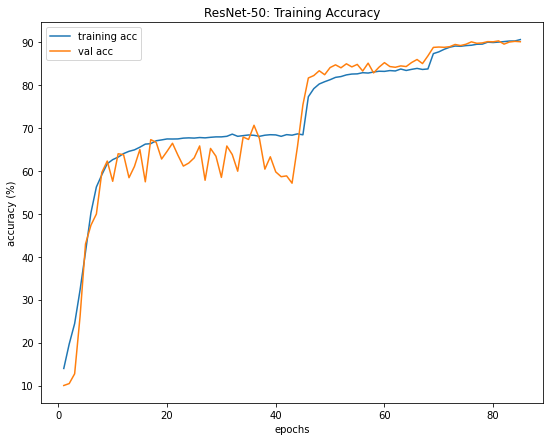

In [42]:
plt.figure(figsize = (9, 7))
plt.plot(list(training_history_lr_scheduler.keys()), [training_history_lr_scheduler[k]['acc'] for k in training_history_lr_scheduler.keys()], label = 'training acc')
plt.plot(list(training_history_lr_scheduler.keys()), [training_history_lr_scheduler[k]['val_acc'] for k in training_history_lr_scheduler.keys()], label = 'val acc')
plt.title("ResNet-50: Training Accuracy")
plt.xlabel("epochs")
plt.ylabel("accuracy (%)")
plt.legend(loc = 'best')
plt.show()

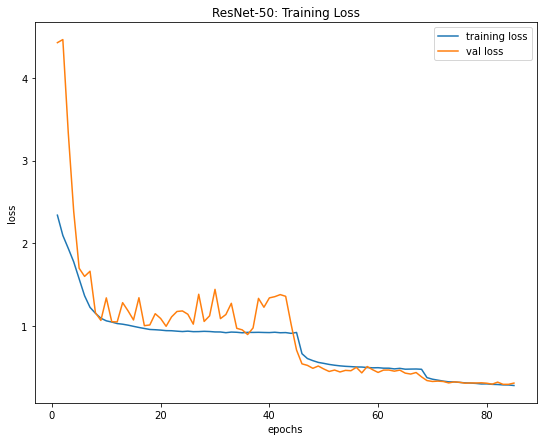

In [43]:
plt.figure(figsize = (9, 7))
plt.plot(list(training_history_lr_scheduler.keys()), [training_history_lr_scheduler[k]['loss'] for k in training_history_lr_scheduler.keys()], label = 'training loss')
plt.plot(list(training_history_lr_scheduler.keys()), [training_history_lr_scheduler[k]['val_loss'] for k in training_history_lr_scheduler.keys()], label = 'val loss')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend(loc = 'best')
plt.title("ResNet-50: Training Loss")
plt.show()

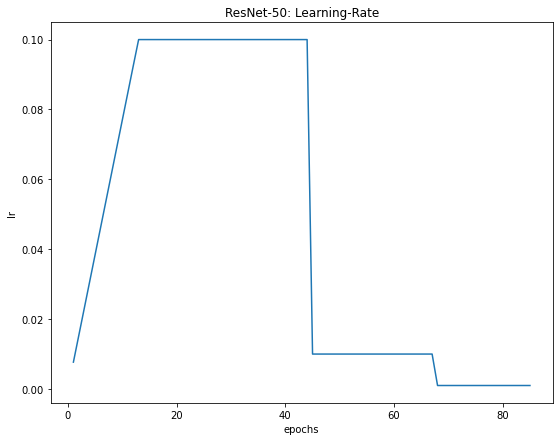

In [44]:
plt.figure(figsize = (9, 7))
plt.plot(list(training_history_lr_scheduler.keys()), [training_history_lr_scheduler[k]['lr'] for k in training_history_lr_scheduler.keys()])
plt.xlabel("epochs")
plt.ylabel("lr")
plt.title("ResNet-50: Learning-Rate")
plt.show()